In [1]:
'''
Details for LRW dataset:
- 500 words (check lrw_list.txt)
- 800-1000 train videos per word
- 50 test and 50 validation videos per word
- Split into train, test, and validation sets
- All videos are 29 frames long (1.16 seconds)
- Word occurs roughly in the middle

TODO: (update as completed)
- Switch labels to numeric or one-hot (currently strings)
- Experiement with transformations of the data
- Experiement with trimming the video to cut out unneeded words, and reduce number of frames
'''

import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import pytorchvideo #look up how to use this
import cv2
import math
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from IPython.display import Video, HTML
from playsound import playsound
from tqdm import tqdm
torch.cuda.empty_cache()

NUM_FRAMES = 29 # Make sure to set all new videos to this length
FPS = 25
TIME = 1.16
NUM_CLASSES = 500

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
random.seed(time.time())
RANDOM_SEED = random.randint(0, 2**32 - 1)


In [2]:
class LipReadDataset(Dataset):
    def __init__(self, root_dir, split, device, transform=None):
        """
        Initialize the dataset.
        Args:
            video_paths (list): List of file paths to video files.
            labels (list): List of corresponding labels.
            transform (callable, optional): Optional data transformations (e.g., resizing, normalization).
        """
        # self.word_folders = 
        # print(self.word_folders)
        # self.frames = []
        self.frame_titles = []
        self.labels = []
        self.device = device
        self.word_dict = {}
        self.num_classes = 0
        self.transform = transform
        # self.split = split
        # self.prefix = root_dir
        random.seed(RANDOM_SEED) #ensure words are the same bewtween datasets
        word_folders = os.listdir(root_dir)
        random.shuffle(word_folders)

        for word_folder in word_folders:
            set_path = os.path.join(root_dir, word_folder, split)
            self.word_dict[word_folder] = self.num_classes
            self.num_classes += 1
            # want to test with 10 words first
            if self.num_classes == NUM_CLASSES:
                break
            num_videos = 0
            video_files = os.listdir(set_path)
            random.seed(time.time()) #shuffle videos randomly
            random.shuffle(video_files)
            for video_file in video_files:
                video_path = os.path.join(set_path, video_file)
                if video_path.endswith('.txt'): # want to use later
                    continue
                num_videos += 1
                if num_videos == 500:
                    break
                # curr_frames = self.extract_frames(video_path)
                self.labels.append(word_folder)
                # self.frames.append(curr_frames)
                self.frame_titles.append(video_path)
                # print(f"added {video_path} to {split} set")
        self.transform = transform
        assert self.num_classes == len(self.word_dict)

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Get a specific sample from the dataset.
        Args:
            idx (int): Index of the sample.
        Returns:
            video (tensor): Video frames (e.g., as a sequence of images).
            label (int): Corresponding label.
        """
        # extract video
        # Apply any necessary transformations (e.g., resizing, normalization)
        # if self.transform:
        #     video = self.transform(video)
        # Convert the label to a one-hot encoded tensor
        return self.extract_frames(self.frame_titles[idx]), self.one_hot_encode(self.labels[idx])
    
    def one_hot_encode(self, labels):
        # Convert labels to one-hot encoding
        one_hot = torch.zeros(NUM_CLASSES, device=self.device)
        one_hot[self.word_dict[labels]] = 1
        return one_hot
        

    def extract_frames(self, video_path, duration=1.16, target_resolution = (40,65)):
        # Read the video
        cap = cv2.VideoCapture(video_path)
        # EXPERIEMENT WITH THIS
        # duration_frames = int(duration * FPS)
        # end_frame = NUM_FRAMES -  9 # skip the last 9 frames
        # start_frame = end_frame - duration_frames # get middle frames
        frames = []
        # cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                # if cap.get(cv2.CAP_PROP_POS_FRAMES) == end_frame:
                #     break
                frame_cropped = frame[120:200, 70:200] # Crop the frame
                # frame_resized = cv2.resize(frame_cropped, target_resolution)
                if self.transform:
                    frame_tensor = self.transform(frame_cropped)
                # frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
                # frame_tensor = torch.from_numpy(frame_gray).to(self.device)
                frame_tensor.to(self.device) #double check
                frames.append(frame_tensor)
            else:
                break
        cap.release()
        video_tensor = torch.stack(frames, dim=0).to(self.device)
        # video_tensor = video_tensor.permute(1, 0, 2, 3)  # assuming the original channel dimension is at index 1
        return video_tensor






In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert frames to PyTorch tensors
    # transforms.Resize((40, 65)),  # Resize frames to smaller resolution
    transforms.Grayscale(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    lambda x: x.to(device)  # Move tensors to device
])

root_dir = 'lipread_mp4'
trainset = LipReadDataset(root_dir, split='train', device=device, transform=transform)
print("finished trainset")
testset = LipReadDataset(root_dir, split='test',device=device, transform=transform)
print("finished testset")
valset = LipReadDataset(root_dir, split='val', device=device, transform=transform)
print("finished valset")

In [4]:
#send to dataloader
batch_size = 32
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True)

In [5]:
# # # # TESTING IMAGE SIZE FOR CROP
# video_path = trainset.frame_titles[2]

# # def loop_video(video_path, loop_count, duration = 0.27):
# #     # Read the video
# #     cap = cv2.VideoCapture(video_path)
# #     duration_frames = round(duration * FPS)
# #     end_frame = NUM_FRAMES -  9 # skip the last 9 frames
# #     start_frame = end_frame - duration_frames - 3  # get middle frames
# #     print(end_frame, start_frame)
# #     frames = []
# #     cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
# #     # Loop the video
# #     frame_count = 0
# #     for _ in range(loop_count):
# #         cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)  # Set frame position to the beginning
# #         while cap.isOpened():
# #             ret, frame = cap.read()
# #             if ret:
# #                 frame_count += 1
# #                 if cap.get(cv2.CAP_PROP_POS_FRAMES) == end_frame:
# #                     break
# #                 frame_cropped = frame[120:200, 70:200]
# #                 cv2.imshow('Looped Video', frame_cropped)
# #                 if cv2.waitKey(25) & 0xFF == ord('q'):
# #                     break
# #             else:
# #                 break
# #     print(frame_count)
    
# #     # Release video capture
# #     cap.release()
# #     cv2.destroyAllWindows()

# # loop_video(video_path, 10)
# print(video_path)
# def extract_frames( video_path, duration=1.16, target_resolution = (40,65), transform=None):
#     # Read the video
#     cap = cv2.VideoCapture(video_path)
#     # EXPERIEMENT WITH THIS
#     # duration_frames = int(duration * FPS)
#     # end_frame = NUM_FRAMES -  9 # skip the last 9 frames
#     # start_frame = end_frame - duration_frames # get middle frames
#     frames = []
#     # cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

#     while cap.isOpened():
#         ret, frame = cap.read()
#         if ret:
#             # if cap.get(cv2.CAP_PROP_POS_FRAMES) == end_frame:
#             #     break
#             frame_cropped = frame[120:200, 70:200] # Crop the frame
#             #downscale the image by half to 40x65
#             # frame_cropped = cv2.resize(frame_cropped, target_resolution)
#             # frame_resized = cv2.resize(frame_cropped, target_resolution)
#             if transform:
#                 frame_tensor = transform(frame_cropped)
#             # frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
#             # frame_tensor = torch.from_numpy(frame_gray).to(self.device)
#             frame_tensor = frame_tensor.to('cpu').numpy()
#             frames.append(frame_tensor)
#         else:
#             break
#     #show video for 10 loops
#     loop_count = 10
#     frame_count = 0
#     cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
#     for i in range(loop_count):
#         cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
#         for frame in frames:
#             print(frame.shape)
#             frame_count += 1
#             cv2.imshow('Looped Video', frame[0])
#             if cv2.waitKey(25) & 0xFF == ord('q'):
#                 break
#     cap.release()
#     cv2.destroyAllWindows()
#     # return video_tensor

# extract_frames(video_path, transform=transform)





In [6]:
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size - 1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

import torch.nn as nn
from torch.nn.utils import weight_norm

import torch
import torch.nn as nn
import torchvision

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class ResTCN(nn.Module):
    def __init__(self, num_classes):
        super(ResTCN, self).__init__()

        self.spatial_feat_dim = 32
        self.num_classes = num_classes
        self.nhid = 128
        self.levels = 8
        self.kernel_size = 7
        self.dropout = .1
        self.channel_sizes = [self.nhid] * self.levels

        self.tcn = TemporalConvNet(
            self.spatial_feat_dim,
            self.channel_sizes,
            kernel_size=self.kernel_size,
            dropout=self.dropout)
        self.linear = nn.Linear(self.channel_sizes[-1], self.num_classes)

        self.model_conv = torchvision.models.resnet18(pretrained=True)

        #change to grayscale

        self.model_conv.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # for param in self.model_conv.parameters():
        #     param.requires_grad = False

        num_ftrs = self.model_conv.fc.in_features
        # self.model_conv.fc = nn.Linear(num_ftrs, 4)
        self.model_conv.fc = nn.Linear(num_ftrs, self.spatial_feat_dim)
        # self.model_conv.fc = Identity()

        # self.rnn = nn.LSTM(self.spatial_feat_dim, 64, 1, batch_first=True)
        # self.linear = nn.Linear(64, 4)

    def forward(self, data):
        # t = 0
        # x = data[:, t, :, :, :]
        # output = self.model_conv(x)

        z = torch.zeros([data.shape[0], data.shape[1], self.spatial_feat_dim]).cuda()
        for t in range(data.size(1)):
            x = self.model_conv(data[:, t, :, :, :])
            z[:, t, :] = x

        # y, _ = self.rnn(z)
        # output = self.linear(torch.sum(y, dim=1))

        z = z.transpose(1, 2)
        y = self.tcn(z)
        # output = self.linear(y[:, :, -1])
        output = self.linear(torch.sum(y, dim=2))

        return output


In [7]:
def plot(loss, acc, title):
    fig, ax = plt.subplots(2)
    fig.tight_layout(pad=3.0)
    fig.suptitle(f'{title} Results')
    ax[0].plot(loss)
    ax[0].set_title(f'{title} Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[1].plot(acc)
    ax[1].set_title(f'{title} Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    plt.show()

In [8]:
def train_and_val(model, train_loader, val_loader, optimizer, criterion, num_epochs=5):
    model.train()
    train_loss_epoch = []
    train_acc_epoch = []
    val_loss_epoch = []
    val_acc_epoch = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_total = 0
        train_correct = 0
        val_loss = 0.0
        val_total = 0
        val_correct = 0
        for data in tqdm(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, labels_class = labels.max(dim=1)  
            _, predicted_class = outputs.max(dim=1)  
            train_correct += (predicted_class == labels_class).sum().item()
            
            train_total += labels.size(0)
            #print
            train_loss += loss.item()
        

        #save model with name based on time
        epoch_state_dict = {'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}
        torch.save(epoch_state_dict, f'cnn2_{int(time.time())}.pth')
        # Validation
        model.eval()
        with torch.no_grad():
            for data in tqdm(val_loader):
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, labels_class = labels.max(dim=1)  
                _, predicted_class = outputs.max(dim=1)  
                val_correct += (predicted_class == labels_class).sum().item()
                val_total+= labels.size(0)
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        print(f'Epoch {epoch + 1}\nTrain Loss: {train_loss }, Accuracy: {100 * train_correct / train_total}% \nVal Loss: {val_loss}, Accuracy: {100 * val_correct / val_total}%')
        train_loss_epoch.append(train_loss)
        train_acc_epoch.append(100 * train_correct / train_total)
        val_loss_epoch.append(val_loss)
        val_acc_epoch.append(100 * val_correct / val_total)
    plot(train_loss_epoch, train_acc_epoch, 'Training')
    plot(val_loss_epoch, val_acc_epoch, 'Validation')

    print('Finished Training')




def test(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in tqdm(test_loader):
            inputs, labels = data
            outputs = model(inputs)
            # print(labels.shape, outputs.shape)
            _, labels_class = labels.max(dim=1)  
            _, predicted_class = outputs.max(dim=1)  
            test_correct += (predicted_class == labels_class).sum().item()
            # print(predicted_class, labels_class, correct)
            # accuracy = correct_predictions / labels.size(0)  
            test_total += labels.size(0)
    print(f'Accuracy: {100 * test_correct / test_total}%')




In [9]:
# cnn1 = CNN1(num_frames=NUM_FRAMES, height=80, width=130, channels=1, num_classes=NUM_CLASSES)
# cnn3 = CNN3(num_frames=NUM_FRAMES, height=80, width=130, channels=1, num_classes=NUM_CLASSES)
restcn = ResTCN(NUM_CLASSES).to(device)
criterion1 = nn.CrossEntropyLoss()
# optimizer1 = optim.Adam(cnn1.parameters(), lr=0.0001)
optimizer2 = optim.Adam(restcn.parameters(), lr=0.0001)
# optimizer3 = optim.Adam(cnn3.parameters(), lr=0.0001)
# cnn1.to(device)


restcn.to(device)
# cnn3.to(device)




c:\Users\coler\anaconda3\envs\ec523\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
c:\Users\coler\anaconda3\envs\ec523\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\coler\anaconda3\envs\ec523\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResTCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(32, 128, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (conv2): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.1, inplace=False)
        (net): Sequential(
          (0): Conv1d(32, 128, kernel_size=(7,), stride=(1,), padding=(6,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
          (4): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(6,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.1, inplace=False)
        )
        (downsample): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(128, 128, kernel_size=(7,), 

100%|██████████| 780/780 [08:30<00:00,  1.53it/s]


Epoch 1
Train Loss: 5.620528279678033, Accuracy: 2.9349279721768187% 
Val Loss: 3.892986191236056, Accuracy: 14.845691382765532%


100%|██████████| 780/780 [08:30<00:00,  1.53it/s]


Epoch 2
Train Loss: 2.9026859892851524, Accuracy: 30.261725856522666% 
Val Loss: 2.523423096155509, Accuracy: 37.859719438877754%


100%|██████████| 780/780 [08:31<00:00,  1.53it/s]


Epoch 3
Train Loss: 2.1012022061447224, Accuracy: 45.60021847301818% 
Val Loss: 2.2155669475213076, Accuracy: 44.27254509018036%


100%|██████████| 780/780 [08:27<00:00,  1.54it/s]


Epoch 4
Train Loss: 1.7162053403527164, Accuracy: 53.80620961361601% 
Val Loss: 2.0543249064531084, Accuracy: 47.899799599198396%


100%|██████████| 780/780 [08:39<00:00,  1.50it/s]


Epoch 5
Train Loss: 1.4259117908969203, Accuracy: 60.45196605636122% 
Val Loss: 1.9792484286503913, Accuracy: 50.392785571142284%


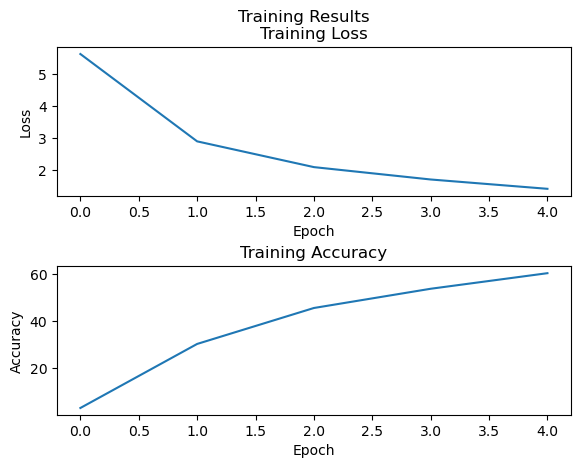

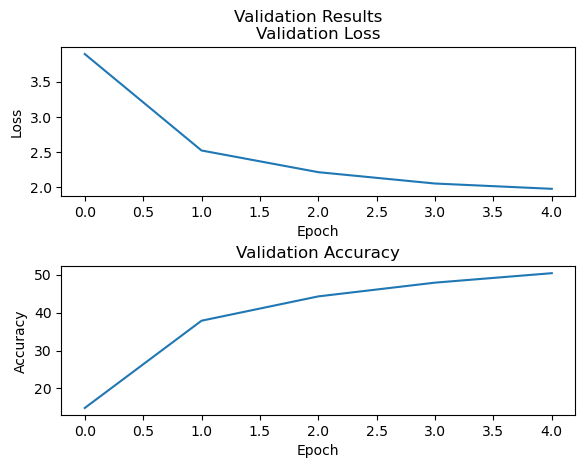

Finished Training
Accuracy: 49.35871743486974%


In [10]:
# training got interrupted so I will load the model from the last checkpoint


train_and_val(restcn, train_loader, val_loader, optimizer2, criterion1, num_epochs=5)
test(restcn, test_loader)
cnn2_state_dict = {'model_state_dict': restcn.state_dict(), 'optimizer_state_dict': optimizer2.state_dict()}
torch.save(cnn2_state_dict, 'full_res_tcn.pth')